In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.41MB/s]


# Variational AutoEncoder
A **Variational Autoencoder (VAE)** is a generative model that learns a lower-dimensional **latent** representation of complex data. It features an **encoder** that maps input data to a probability distribution in this latent space, and a **decoder** that reconstructs the data from a sample taken from this distribution. A key aspect of training VAEs is the **reparameterization trick**.


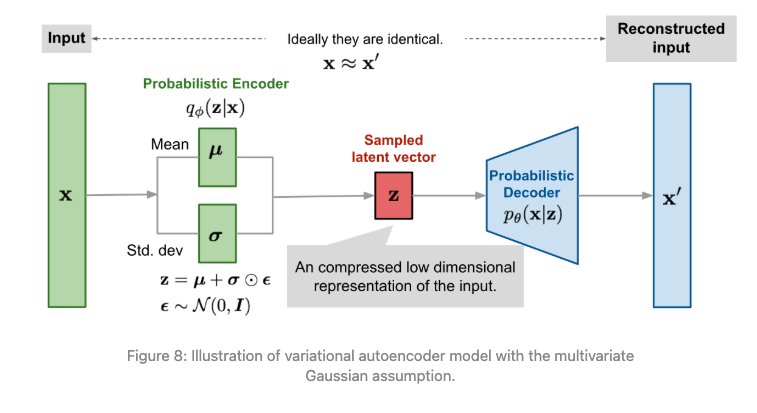

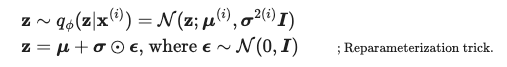

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)  # Mean of the latent space
        self.fc22 = nn.Linear(h_dim, z_dim)  # Log variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, x_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def sample_latent(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.sample_latent(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train

In [6]:
x_dim = 784
h_dim = 400
# z_dim = 2
z_dim = 20

model = VAE(x_dim, h_dim, z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Training for 10 epochs
for epoch in range(1, 11):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.802795
Train Epoch: 1 [3200/60000 (5%)]	Loss: 206.785767
Train Epoch: 1 [6400/60000 (11%)]	Loss: 158.814713
Train Epoch: 1 [9600/60000 (16%)]	Loss: 156.459045
Train Epoch: 1 [12800/60000 (21%)]	Loss: 149.824539
Train Epoch: 1 [16000/60000 (27%)]	Loss: 136.411026
Train Epoch: 1 [19200/60000 (32%)]	Loss: 137.673340
Train Epoch: 1 [22400/60000 (37%)]	Loss: 134.443100
Train Epoch: 1 [25600/60000 (43%)]	Loss: 128.021851
Train Epoch: 1 [28800/60000 (48%)]	Loss: 129.661621
Train Epoch: 1 [32000/60000 (53%)]	Loss: 113.611725
Train Epoch: 1 [35200/60000 (59%)]	Loss: 119.043686
Train Epoch: 1 [38400/60000 (64%)]	Loss: 119.905457
Train Epoch: 1 [41600/60000 (69%)]	Loss: 130.546204
Train Epoch: 1 [44800/60000 (75%)]	Loss: 125.883461
Train Epoch: 1 [48000/60000 (80%)]	Loss: 116.905449
Train Epoch: 1 [51200/60000 (85%)]	Loss: 110.938126
Train Epoch: 1 [54400/60000 (91%)]	Loss: 121.155846
Train Epoch: 1 [57600/60000 (96%)]	Loss: 115.183830
====> Epoch: 1 Averag

====> Test set loss: 104.9301


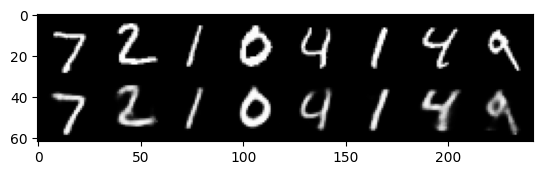

In [7]:
def test(model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += vae_loss(recon, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon.view(batch_size, 1, 28, 28)[:n]])

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return comparison.cpu()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

comparison = test(model)

nrow = 8
imshow(torchvision.utils.make_grid(comparison.data, nrow=nrow))

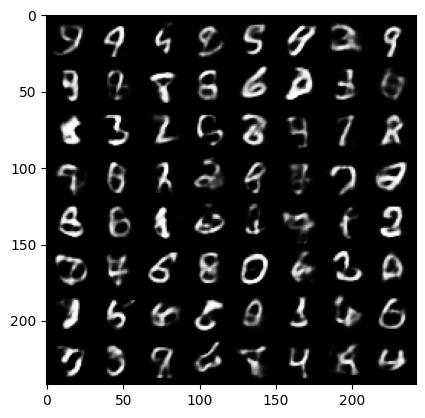

In [8]:
with torch.no_grad():
    sample = torch.randn(64, z_dim).to(device)
    sample = model.decode(sample).cpu()
imshow(torchvision.utils.make_grid(sample.view(-1,1,28,28).data, nrow=nrow))

In [9]:
for epoch in range(11, 21):
    train(epoch)

Train Epoch: 11 [0/60000 (0%)]	Loss: 99.593491
Train Epoch: 11 [3200/60000 (5%)]	Loss: 105.413391
Train Epoch: 11 [6400/60000 (11%)]	Loss: 101.567474
Train Epoch: 11 [9600/60000 (16%)]	Loss: 106.757568
Train Epoch: 11 [12800/60000 (21%)]	Loss: 112.272018
Train Epoch: 11 [16000/60000 (27%)]	Loss: 106.502686
Train Epoch: 11 [19200/60000 (32%)]	Loss: 103.328110
Train Epoch: 11 [22400/60000 (37%)]	Loss: 104.509880
Train Epoch: 11 [25600/60000 (43%)]	Loss: 96.570358
Train Epoch: 11 [28800/60000 (48%)]	Loss: 108.421425
Train Epoch: 11 [32000/60000 (53%)]	Loss: 113.840576
Train Epoch: 11 [35200/60000 (59%)]	Loss: 114.152222
Train Epoch: 11 [38400/60000 (64%)]	Loss: 110.389763
Train Epoch: 11 [41600/60000 (69%)]	Loss: 106.462173
Train Epoch: 11 [44800/60000 (75%)]	Loss: 104.816864
Train Epoch: 11 [48000/60000 (80%)]	Loss: 100.902649
Train Epoch: 11 [51200/60000 (85%)]	Loss: 105.894608
Train Epoch: 11 [54400/60000 (91%)]	Loss: 105.284622
Train Epoch: 11 [57600/60000 (96%)]	Loss: 103.286171
====

====> Test set loss: 103.4605


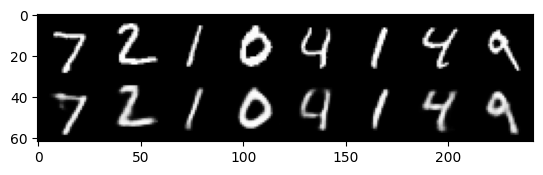

In [10]:
comparison = test(model)

nrow = 8
imshow(torchvision.utils.make_grid(comparison.data, nrow=nrow))

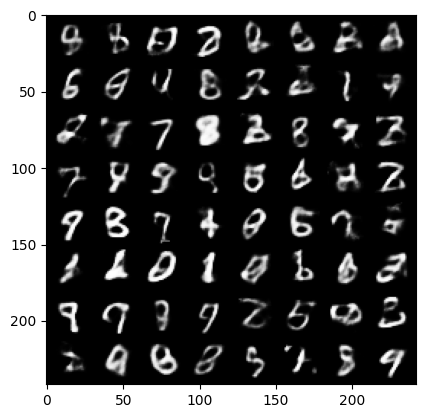

In [11]:
with torch.no_grad():
    sample = torch.randn(64, z_dim).to(device)
    sample = model.decode(sample).cpu()
imshow(torchvision.utils.make_grid(sample.view(-1,1,28,28).data, nrow=nrow))

In [12]:
for epoch in range(21, 31):
    train(epoch)

Train Epoch: 21 [0/60000 (0%)]	Loss: 105.294632
Train Epoch: 21 [3200/60000 (5%)]	Loss: 107.110336
Train Epoch: 21 [6400/60000 (11%)]	Loss: 105.137978
Train Epoch: 21 [9600/60000 (16%)]	Loss: 104.953590
Train Epoch: 21 [12800/60000 (21%)]	Loss: 106.073059
Train Epoch: 21 [16000/60000 (27%)]	Loss: 106.838760
Train Epoch: 21 [19200/60000 (32%)]	Loss: 100.266052
Train Epoch: 21 [22400/60000 (37%)]	Loss: 105.723595
Train Epoch: 21 [25600/60000 (43%)]	Loss: 107.817490
Train Epoch: 21 [28800/60000 (48%)]	Loss: 103.013870
Train Epoch: 21 [32000/60000 (53%)]	Loss: 102.092300
Train Epoch: 21 [35200/60000 (59%)]	Loss: 104.266068
Train Epoch: 21 [38400/60000 (64%)]	Loss: 96.139938
Train Epoch: 21 [41600/60000 (69%)]	Loss: 102.076729
Train Epoch: 21 [44800/60000 (75%)]	Loss: 104.900726
Train Epoch: 21 [48000/60000 (80%)]	Loss: 112.343864
Train Epoch: 21 [51200/60000 (85%)]	Loss: 97.068169
Train Epoch: 21 [54400/60000 (91%)]	Loss: 112.295563
Train Epoch: 21 [57600/60000 (96%)]	Loss: 98.762070
====>

====> Test set loss: 102.8323


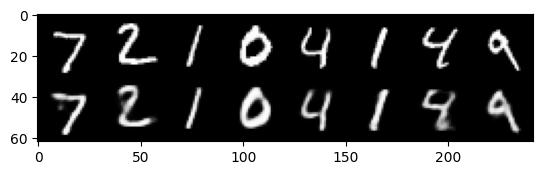

In [13]:
comparison = test(model)

nrow = 8
imshow(torchvision.utils.make_grid(comparison.data, nrow=nrow))

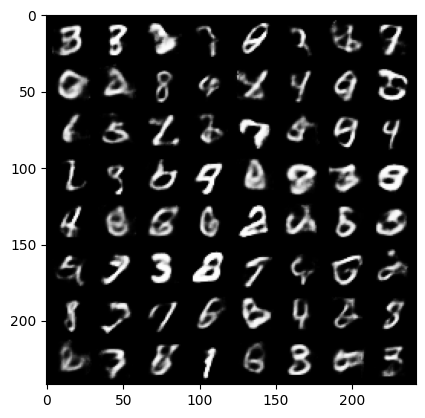

In [14]:
with torch.no_grad():
    sample = torch.randn(64, z_dim).to(device)
    sample = model.decode(sample).cpu()
imshow(torchvision.utils.make_grid(sample.view(-1,1,28,28).data, nrow=nrow))

In [15]:
for epoch in range(31, 51):
    train(epoch)

Train Epoch: 31 [0/60000 (0%)]	Loss: 101.789101
Train Epoch: 31 [3200/60000 (5%)]	Loss: 108.813927
Train Epoch: 31 [6400/60000 (11%)]	Loss: 103.105881
Train Epoch: 31 [9600/60000 (16%)]	Loss: 103.059433
Train Epoch: 31 [12800/60000 (21%)]	Loss: 106.405106
Train Epoch: 31 [16000/60000 (27%)]	Loss: 104.859131
Train Epoch: 31 [19200/60000 (32%)]	Loss: 108.024185
Train Epoch: 31 [22400/60000 (37%)]	Loss: 104.019852
Train Epoch: 31 [25600/60000 (43%)]	Loss: 110.594940
Train Epoch: 31 [28800/60000 (48%)]	Loss: 95.981644
Train Epoch: 31 [32000/60000 (53%)]	Loss: 106.998962
Train Epoch: 31 [35200/60000 (59%)]	Loss: 101.731369
Train Epoch: 31 [38400/60000 (64%)]	Loss: 100.164612
Train Epoch: 31 [41600/60000 (69%)]	Loss: 94.801117
Train Epoch: 31 [44800/60000 (75%)]	Loss: 103.070145
Train Epoch: 31 [48000/60000 (80%)]	Loss: 102.387115
Train Epoch: 31 [51200/60000 (85%)]	Loss: 95.959633
Train Epoch: 31 [54400/60000 (91%)]	Loss: 110.828529
Train Epoch: 31 [57600/60000 (96%)]	Loss: 106.453888
====>

====> Test set loss: 102.2268


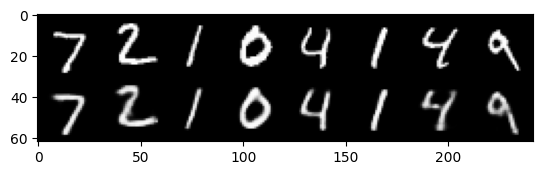

In [16]:
comparison = test(model)

nrow = 8
imshow(torchvision.utils.make_grid(comparison.data, nrow=nrow))

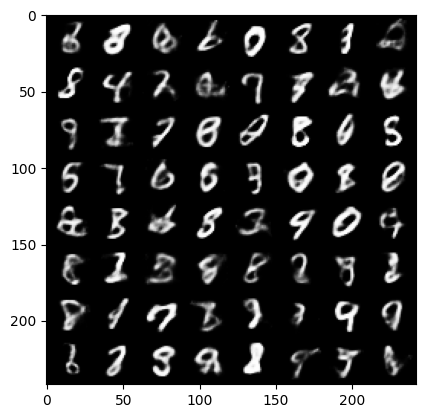

In [17]:
with torch.no_grad():
    sample = torch.randn(64, z_dim).to(device)
    sample = model.decode(sample).cpu()
imshow(torchvision.utils.make_grid(sample.view(-1,1,28,28).data, nrow=nrow))

In [18]:
PATH = './vae_MNIST_zdim20_hdim40.pth'
# PATH = './vae_MNIST_zdim2_hdim40.pth'
torch.save(model.state_dict(), PATH)

# Visualization

## z_dim = 2

In [39]:
model2 = VAE(x_dim, h_dim, 2).to(device)
model2.load_state_dict(torch.load('./vae_MNIST_zdim2_hdim40.pth'))

<All keys matched successfully>

====> Test set loss: 148.3711


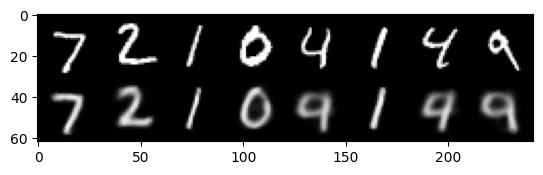

In [40]:
comparison = test(model2)

nrow = 8
imshow(torchvision.utils.make_grid(comparison.data, nrow=nrow))

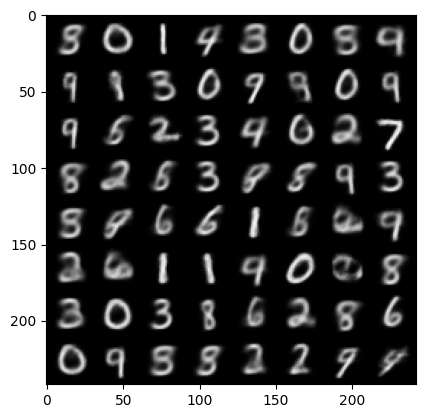

In [41]:
with torch.no_grad():
    sample = torch.randn(64, 2).to(device)
    sample = model2.decode(sample).cpu()
imshow(torchvision.utils.make_grid(sample.view(-1,1,28,28).data, nrow=nrow))

## Display grids of sampled data when z_dim = 2

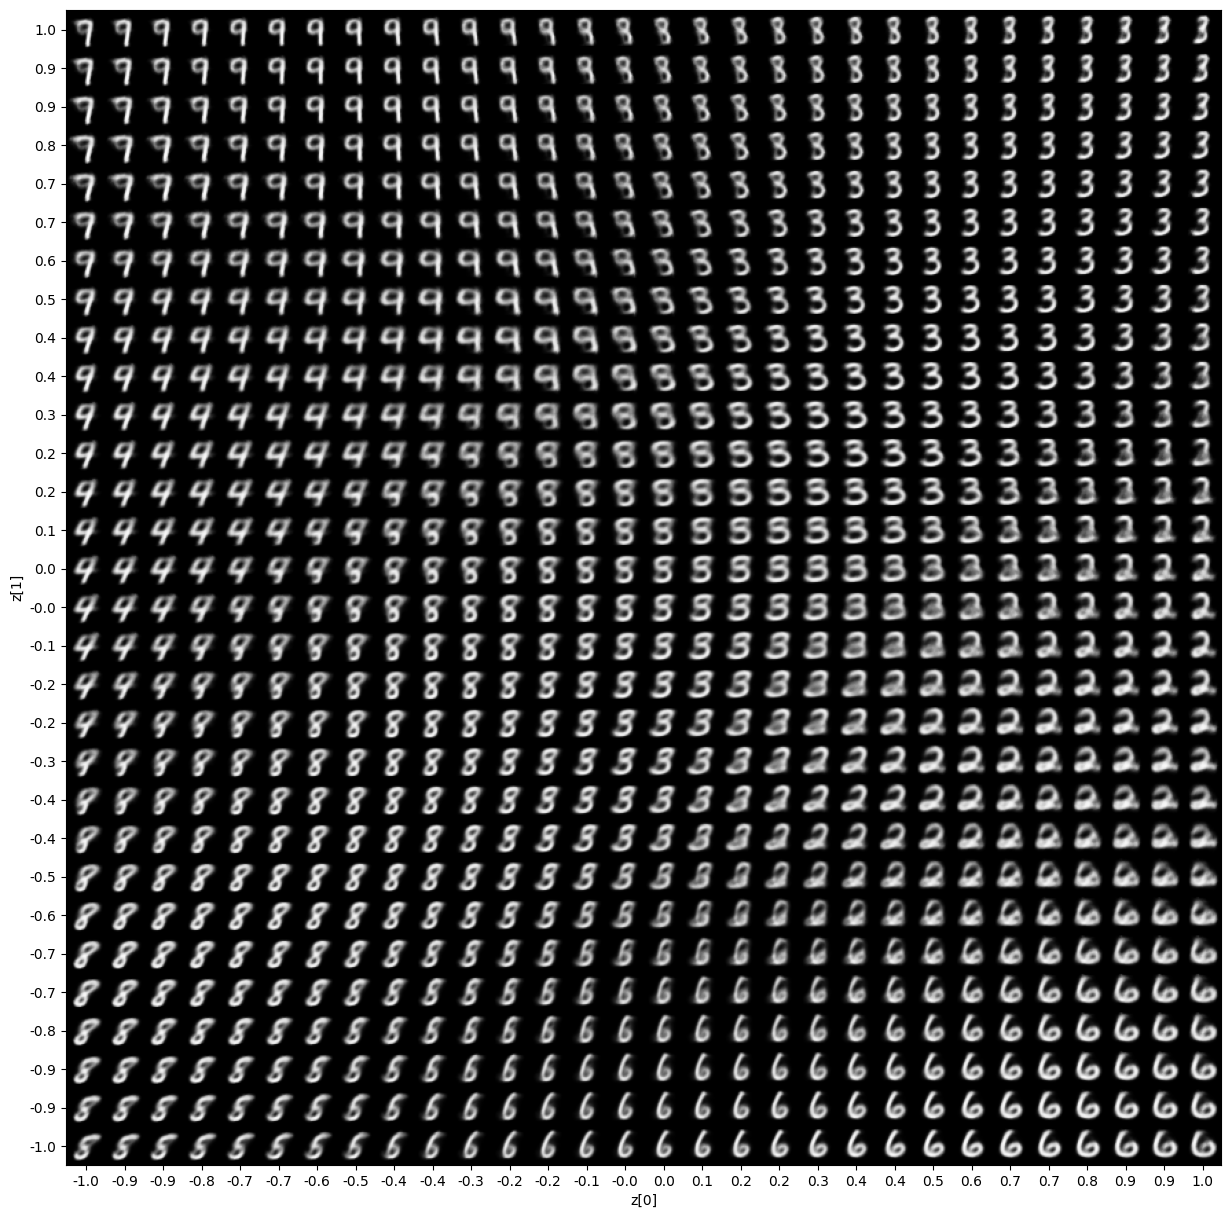

In [42]:
import matplotlib.pyplot as plt


def plot_latent_space(model, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.FloatTensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).detach().cpu().numpy()
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model2)

### Display how the latent space clusters different digit classes

In [43]:
latents = []
labels = []
with torch.no_grad():
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        mu, _ = model2.encode(data.view(-1, 784))
        latents.append(mu)
        labels.append(label)
    latents = torch.cat(latents)
    labels = torch.cat(labels)


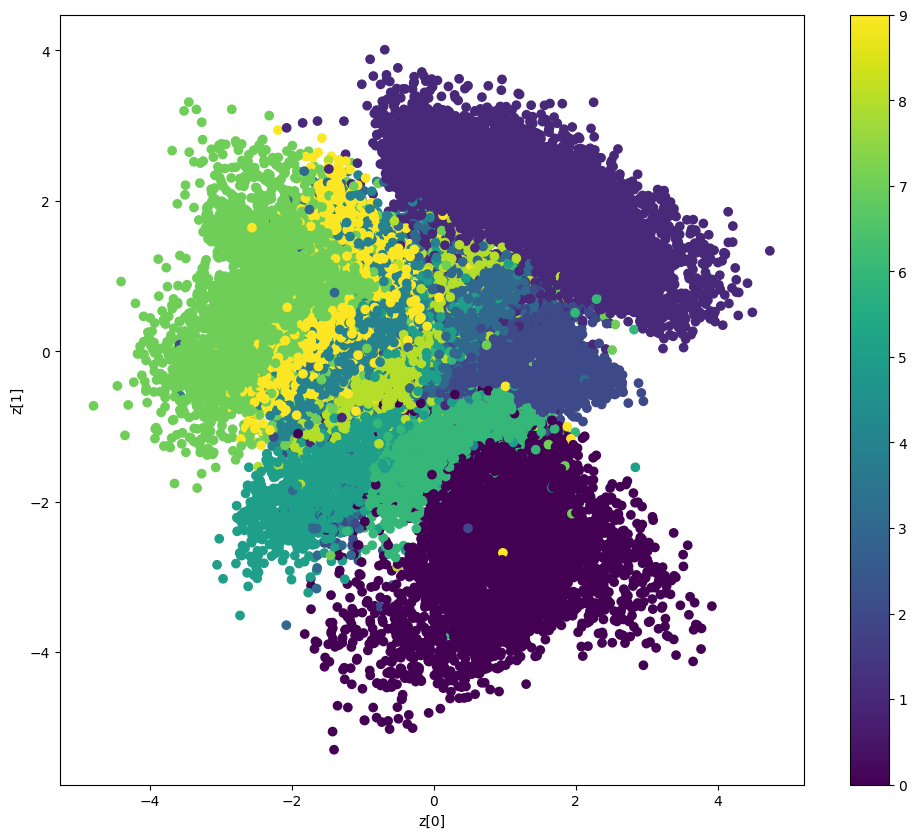

In [44]:
def to_np(tensor):
    return tensor.cpu().numpy()
latents = to_np(latents)
labels = to_np(labels)

plt.figure(figsize=(12, 10))
plt.scatter(latents[:, 0], latents[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()